In [2]:
library('base64enc');
library('stringr');
library('dplyr');
library('tidyr');
library('ggplot2');
library('stringr');
library(readr)
library(knitr)
library(kableExtra)
library(IRdisplay)
library("ggVennDiagram")
library(hrbrthemes)
library(extrafont)

extrafont::loadfonts()

options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
extractExceptionName <- function(firstLine){
    ret <- str_match(firstLine, "([^:]+)")
    ret[1]
}
decodeTrace <- function(enc) {
    rawToChar(base64decode(as.character(enc)))
}
convertTestName <- function(t){
    parts <- str_match(t,"(.+)\\.(.+)")
    paste(parts[,2],parts[,3],sep="#")
}


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘kableExtra’


The following object is masked from ‘package:dplyr’:

    group_rows


Registering fonts with R

Adobe Caslon Pro Bold already registered with pdfFonts().

Adobe Caslon Pro already registered with pdfFonts().

DejaVu Sans already registered with pdfFonts().

DejaVu Sans Mono already registered with pdfFonts().

DejaVu Serif already registered with pdfFonts().

Droid Sans Fallback already registered with pdfFonts().

FontAwesome already registered with pdfFonts().

GLYPHICONS Halflings already registered with pdfFonts().

Lato Black already registered with pdfFonts().

Lato already registered with pdfFonts().

Lato Hairline already registered with pdfFonts().

Lato Heavy already registered with pdfFonts().

Lato Light already registered with pdfFonts().



## Generate Table 1: The summary of flaky tests and failures found by each technique, along with intersection

In [3]:
# Relies on matched-failures.csv, should be in same directory
matchedFailures <- read_csv("matched-failures.csv",
    col_types = "ccccccdddddd"
) %>% mutate(failingException = extractExceptionName(failureMessage))

intersectionTableByFailure <- matchedFailures %>%
    filter(failureMessage != "SleepyTimeOut(ProbableDeadlock)") %>%
    mutate(
        Found.FlakeFlagger = rerun > 0,
        Found.FlakeFlaggerRepl = flakeFlaggerRepl > 2 & flakeFlaggerRepl < 9000,
        Found.IsolatedRerun = isolatedRerun > 2 & isolatedRerun < 9000,
        Found.FlakeRake = flakerake > 0,
        Found.FlakeRakeOBO = `flakerake-obo` > 0,
        Intersection.FlakeFlagger.FlakeFlaggerRepl = flakeFlaggerRepl > 2 & rerun > 0,
        Intersection.FlakeFlagger.IsolatedRerun = rerun > 0 & isolatedRerun > 2,
        Intersection.FlakeFlagger.FlakeRake = rerun > 0 & flakerake > 0,
        Intersection.FlakeFlagger.FlakeRakeOBO = rerun > 0 & `flakerake-obo` > 0,
    )

intersectionTableByTest <- intersectionTableByFailure %>%
    group_by(slug, test) %>%
    summarise(across(starts_with("Found.") | starts_with("Intersection."), ~ sum(.x, na.rm = TRUE)))

intersectionTableByProj <- intersectionTableByTest %>%
    group_by(slug) %>%
    summarise(across(
        starts_with("Found.") | starts_with("Intersection."),
        list(tests = ~ sum(. != 0, na.rm = TRUE), failures = sum)
    )) %>%
    select(-(starts_with("Intersection") & ends_with("_tests"))) %>%
    bind_rows(summarise(
        .,
        across(where(is.numeric), sum),
        across(where(is.character), ~"\\midrule \\textbf{Total}")
    ))

names(intersectionTableByProj) <- c("Project", "Tests", "Failures", "Tests", "Failures", "Tests", "Failures", "Tests", "Failures", "Tests", "Failures", "\\flakeFlaggerReplShort", "\\isolatedRerunShort", "\\flakeRakeShort", "\\flakeRakeOBOShort")
intersectionTableByProj %>%
    kable("html", booktabs = TRUE, linesep = "", digits = 0, escape = FALSE, format.args = list(
        big.mark = ",",
        scientific = FALSE
    )) %>%
    kable_styling(latex_options = "striped") %>%
    add_header_above(c("", "\\\\flakeFlaggerRerunTechnique" = 2, "\\\\flakeFlaggerReplTechnique" = 2, "\\\\isolatedRerun" = 2, "\\\\flakeRake" = 2, "\\\\flakeRakeOBO" = 2, "\\\\multirow{-2}{*}{\\\\parbox{3cm}{\\\\centering Intersection of Failures with \\\\flakeFlaggerRerunTechnique}}" = 4), escape = FALSE) %>%
    add_header_above(c("", "Flaky Tests & Failures by Technique" = 10, "", "", "", "")) %>%
    as.character() %>%
    display_html()

intersectionTableByProj %>%
    kable("latex", booktabs = TRUE, linesep = "", digits = 0, escape = FALSE, format.args = list(
        big.mark = ",",
        scientific = FALSE
    )) %>%
    kable_styling(latex_options = "striped") %>%
    add_header_above(c("", "\\\\flakeFlaggerRerunTechnique" = 2, "\\\\flakeFlaggerReplTechnique" = 2, "\\\\isolatedRerun" = 2, "\\\\flakeRake" = 2, "\\\\flakeRakeOBO" = 2, "\\\\multirow{-2}{*}{\\\\parbox{3cm}{\\\\centering Intersection of Failures with \\\\flakeFlaggerRerunTechnique}}" = 4), escape = FALSE) %>%
    add_header_above(c("", "Flaky Tests & Failures by Technique" = 10, "", "", "", ""))

`summarise()` has grouped output by 'slug'. You can override using the `.groups` argument.



Flaky Tests & Failures by Technique 
 
 
 
 
 
 
 
 \\flakeFlaggerRerunTechnique 
 \\flakeFlaggerReplTechnique 
 \\isolatedRerun 
 \\flakeRake 
 \\flakeRakeOBO 
 \\multirow{-2}{*}{\\parbox{3cm}{\\centering Intersection of Failures with \\flakeFlaggerRerunTechnique}} 
 
 
 Project 
 Tests 
 Failures 
 Tests 
 Failures 
 Tests 
 Failures 
 Tests 
 Failures 
 Tests 
 Failures 
 \flakeFlaggerReplShort 
 \isolatedRerunShort 
 \flakeRakeShort 
 \flakeRakeOBOShort 
 
 
 
 
 activiti-activiti 
 32 
 32 
 15 
 15 
 6 
 6 
 28 
 95 
 28 
 72 
 15 
 6 
 24 
 24 
 
 
 Alluxio-alluxio 
 116 
 183 
 2 
 2 
 2 
 2 
 55 
 157 
 53 
 122 
 2 
 2 
 28 
 24 
 
 
 apache-ambari 
 52 
 53 
 0 
 0 
 0 
 0 
 1 
 3 
 1 
 3 
 0 
 0 
 2 
 2 
 
 
 apache-commons-exec 
 1 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 apache-hbase 
 145 
 250 
 42 
 42 
 72 
 121 
 89 
 165 
 73 
 91 
 13 
 14 
 15 
 6 
 
 
 apache-httpcore 
 22 
 22 
 5 
 5 
 2 
 2 
 16 
 22 
 16 
 17 
 5 
 2 
 4 
 1 
 
 
 apache-incubator-dubbo 
 19 
 21 
 8 
 8 
 1 
 3 
 6 
 29 
 6 
 27 
 0 
 0 
 0 
 0 
 
 
 doanduyhai-Achilles 
 4 
 4 
 2 
 2 
 2 
 2 
 0 
 0 
 0 
 0 
 2 
 2 
 0 
 0 
 
 
 elasticjob-elastic-job-lite 
 3 
 4 
 0 
 0 
 0 
 0 
 1 
 2 
 1 
 2 
 0 
 0 
 0 
 0 
 
 
 hector-client-hector 
 33 
 33 
 0 
 0 
 0 
 0 
 1 
 1 
 1 
 1 
 0 
 0 
 0 
 0 
 
 
 jknack-handlebars.java 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 1 
 
 
 joel-costigliola-assertj-core 
 1 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 kevinsawicki-http-request 
 18 
 18 
 18 
 18 
 0 
 0 
 0 
 0 
 1 
 1 
 18 
 0 
 0 
 0 
 
 
 ninjaframework-ninja 
 1 
 1 
 0 
 0 
 1 
 1 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 0 
 
 
 orbit-orbit 
 7 
 7 
 2 
 2 
 5 
 5 
 6 
 18 
 7 
 20 
 2 
 5 
 3 
 5 
 
 
 qos-ch-logback 
 22 
 23 
 2 
 2 
 2 
 2 
 16 
 22 
 16 
 22 
 2 
 2 
 12 
 12 
 
 
 spring-projects-spring-boot 
 163 
 287 
 0 
 0 
 11 
 12 
 5 
 24 
 6 
 14 
 0 
 24 
 0 
 1 
 
 
 square-okhttp 
 100 
 121 
 15 
 24 
 12 
 18 
 26 
 41 
 23 
 38 
 22 
 17 
 17 
 13 
 
 
 tootallnate-java-websocket 
 23 
 45 
 22 
 41 
 21 
 36 
 22 
 26 
 21 
 21 
 41 
 36 
 22 
 21 
 
 
 undertow-io-undertow 
 7 
 12 
 1 
 1 
 0 
 0 
 7 
 19 
 7 
 19 
 1 
 0 
 4 
 4 
 
 
 wildfly-wildfly 
 23 
 23 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 
 
 wro4j-wro4j 
 16 
 23 
 2 
 2 
 1 
 1 
 4 
 5 
 4 
 4 
 1 
 1 
 4 
 4 
 
 
 zxing-zxing 
 2 
 2 
 2 
 2 
 2 
 2 
 0 
 0 
 0 
 0 
 2 
 2 
 0 
 0 
 
 
 \midrule \textbf{Total} 
 811 
 1,167 
 139 
 167 
 141 
 214 
 284 
 630 
 265 
 475 
 127 
 115 
 136 
 118

\begin{table}
\centering
\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
\multicolumn{1}{c}{} & \multicolumn{10}{c}{Flaky Tests \& Failures by Technique} & \multicolumn{1}{c}{} & \multicolumn{1}{c}{} & \multicolumn{1}{c}{} & \multicolumn{1}{c}{} \\
\cmidrule(l{3pt}r{3pt}){2-11}
\multicolumn{1}{c}{} & \multicolumn{2}{c}{\flakeFlaggerRerunTechnique} & \multicolumn{2}{c}{\flakeFlaggerReplTechnique} & \multicolumn{2}{c}{\isolatedRerun} & \multicolumn{2}{c}{\flakeRake} & \multicolumn{2}{c}{\flakeRakeOBO} & \multicolumn{4}{c}{\multirow{-2}{*}{\parbox{3cm}{\centering Intersection of Failures with \flakeFlaggerRerunTechnique}}} \\
\cmidrule(l{3pt}r{3pt}){2-3} \cmidrule(l{3pt}r{3pt}){4-5} \cmidrule(l{3pt}r{3pt}){6-7} \cmidrule(l{3pt}r{3pt}){8-9} \cmidrule(l{3pt}r{3pt}){10-11} \cmidrule(l{3pt}r{3pt}){12-15}
Project & Tests & Failures & Tests & Failures & Tests & Failures & Tests & Failures & Tests & Failures & \flakeFlaggerReplShort & \isolatedRerunShort & \flakeRakeShort & \flakeRakeOBOShort\\
\midru

## Generate failure intersection venn diagram, shown in discussion section

Saving 6.67 x 6.67 in image



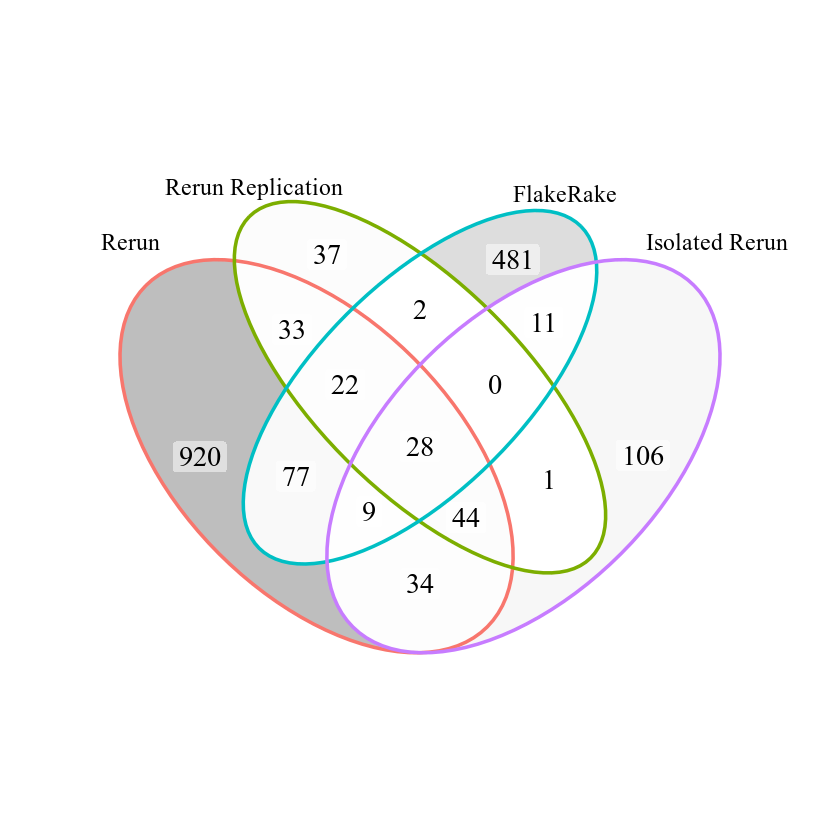

In [4]:
x <- matchedFailures  %>% 
filter(failureMessage != "SleepyTimeOut(ProbableDeadlock)") %>%
select(rerun, flakeFlaggerRepl, flakerake,  isolatedRerun) %>%
    mutate_if(is.numeric, ~replace(., is.na(.), 0)) %>%
    mutate(
    flakeFlaggerRepl = case_when(flakeFlaggerRepl > 2~flakeFlaggerRepl, TRUE~0),
    isolatedRerun = case_when(isolatedRerun > 2~isolatedRerun, TRUE~0)
)

colnames(x)=c("Rerun","Rerun Replication","FlakeRake", "Isolated Rerun")
venn <- Venn(lapply(x, function(x) which(x>0)))
data <- process_data(venn)
ggplot() +
  geom_sf(aes(fill=count), data = data@region) +
  geom_sf(aes(color = id), size = 1,data = data@setEdge, show.legend = F) +
  geom_sf_text(aes(label = name), data = data@setLabel, size=5, family = "Times New Roman") +
  geom_sf_label(aes(label=count), family = "Times New Roman", size = 6,
                color = "black", label.size = NA, alpha = 0.5, data = data@region) +
  ggplot2::scale_fill_gradient(low="white",high = "grey")+scale_x_continuous(expand = expansion(mult = .2))+
  theme_void() +   theme(legend.position = "none")

# ggsave("failure-intersection.pdf")


In [5]:
# Collects statistics for the failure described in the background section
matchedFailures %>%
    filter(test == 'ch.qos.logback.classic.net.SMTPAppender_GreenTest#testCustomBufferSize') %>%
    select(flakerake,rerun,isolatedRerun,flakeFlaggerRepl)

flakerake,rerun,isolatedRerun,flakeFlaggerRepl
<dbl>,<dbl>,<dbl>,<dbl>
6,1,NA,NA


In [6]:
# How many tests do we think are TD? This is the number of tests that flakerake or flakerake-obo found any failure for
nrow(matchedFailures %>% filter(flakerake > 0 | `flakerake-obo` > 0) %>% group_by(test) %>% summarise(count=n()))

[1] 290

In [7]:
# Some numbers for the paper
# \newcommand{\unionOBOBISTestsPerc}{48\%\xspace} % \unionOBOBISTests / \flakeFlaggerTests
unionOBOBISTestsCount <- matchedFailures %>%
    filter(flakerake > 0 | `flakerake-obo` > 0) %>% group_by(test) %>% summarise(count=n()) 
unionOBOBISTestsCount

[1] 1.266376